# Load Libraries

In [1]:
import sys, os, pygmt, importlib, re, base64
import numpy              as np
import pandas             as pd
import xarray             as xr
import xesmf              as xe
import matplotlib.pyplot  as plt
import matplotlib.dates   as mdates
from matplotlib.offsetbox import AnchoredOffsetbox, VPacker, TextArea
from datetime             import timedelta, date, datetime
from pathlib              import Path
from dask.distributed     import Client, LocalCluster
from collections          import defaultdict
from scipy.interpolate    import interp1d
from pyproj               import CRS, Transformer
from IPython.display      import Image, HTML, Video
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox      import SeaIceToolbox

## reload SeaIceToolbox if local changes have been made

In [4]:
import sys
import importlib
# Step 1: Clear all relevant modules
for mod in list(sys.modules):
    if mod.startswith("sea_ice_toolbox") or mod.startswith("sea_ice_"):
        del sys.modules[mod]
# Step 2: Explicit reloads in dependency order
import sea_ice_plotter
import sea_ice_classification
import sea_ice_icebergs
import sea_ice_observations
import sea_ice_metrics
import sea_ice_toolbox
importlib.reload(sea_ice_plotter)
importlib.reload(sea_ice_classification)
importlib.reload(sea_ice_icebergs)
importlib.reload(sea_ice_observations)
importlib.reload(sea_ice_metrics)
importlib.reload(sea_ice_toolbox)
# Step 3: Re-import key class from module (to refresh the class definition)
from sea_ice_toolbox import SeaIceToolbox

# ACCESS-OM2-025-ERA5 sea ice data ( **needs only to be run once, after which data can be extracted from local zarr files** )
+ this uses [ACCESS-NRI intake catalog](https://access-nri-intake-catalog.readthedocs.io/en/latest/index.html) through a ``SeaIceToolbox`` method ``load_ACCESS_OM_CICE``

In [ ]:
dt0_str        = "1993-01-01"
dtN_str        = "1999-12-31"
dt_rng_str     = f"{dt0_str[:4]}-{dtN_str[:4]}"
ice_type       = "FI_BT"
SIA_dict       = {}
FIA_dict       = {}
SI_tools       = SeaIceToolbox(sim_name             = "AOM2-ERA5",
                               dt0_str              = dt0_str,
                               dtN_str              = dtN_str,
                               ice_speed_threshold  = 5e-4,
                               ice_speed_type       = "BT",
                               ice_type             = "FI_BT",
                               overwrite_zarr       = True,
                               save_new_figs        = True,
                               show_figs            = True,
                               overwrite_saved_figs = True)

## load ACCESS-OM-025-ERA5 data from ESM datastore then convert to zarr files for easy of use later
+ loading and saving only needs to be done if it has not been done previously
+ running both of these cells takes approximately an hour with the bottleneck at writing to zarr

In [ ]:
AOM2 = SI_tools.load_ACCESS_OM_CICE()

In [ ]:
SI_tools.write_ACCESS_to_monthly_zarr(AOM2, overwrite=True)

## run ACCESS-OM-025-ERA5 through fast ice classification workflow
+ this is a quick process and will save masked zarr dataset

In [ ]:
AOM2_FI_raw = SI_tools.process_daily_cice(ispd_thresh=5e-4,
                                          ivec_type="BT",
                                          overwrite_zarr_group=True)

In [ ]:
AOM2_FI_roll = SI_tools.process_rolling_cice(ispd_thresh=5e-4,
                                             ivec_type="BT",
                                             overwrite_zarr_group=True)

# <span style="color: red;">Study Objectives</span>

## Can a realistic simulation of circumpolar Antarctic fast ice be achieved in CICE-standalone?

+ Sea ice area and volum comparisons are done against [NSIDC](https://nsidc.org/data/g02202/versions/4) and [ACCESS-OM2-025-IAF-ERA](https://forum.access-hive.org.au/t/era-5-forced-access-om2-simulations/1103) (``AOM2-ERA``). The rationale is to show two of my simulations ([AFIM](https://github.com/dpath2o/AFIM), *CICE6-standalone*) against both NSIDC and ACCESS-OM2 as a relative overall gauge of AFIM performance.

+ I've chosen two related AFIM simulations: ``elps-min`` and ``gi-nil``. Both of which have ellispse eccentrincities ($e_{f}=e_{g}=1.2$, and further just abbreviated $e$) and tensile stress parameter ($k_{t}=0.2$) and all other CICE namelist parameters set to *default* standalone configuration, with the exception of the landmask file used (``kmt_file``). ``elps-min`` uses a modified landmask where 25% of the non-isolated grounded iceberg cells remain, whereas ``gi-nil`` uses the same landmask file as ``AOM2-ERA5`` and hence has no grounded iceberg cells.
  
+ Animations of daily sea ice speed ($\sqrt(u^2 + v^2)$) are then shown of the above two AFIM simulations along with AOM2-ERA5 for the same period (Austral winter 1999). Implicitly, the animations show the effect of $e$ and $ktens$ on the coastal icepack, and for the ``elps-min`` simulation the animation clearly shows the significance of grouned icebergs. 

### Sea Ice Area and Volume Comparisons

In [12]:
SIA_dict  = {}
SIV_dict  = {}
FIA_dict  = {}
FIV_dict  = {}
sim_names = ["elps-min", "gi-nil", "AOM2-ERA5"]
for sim in sim_names:
    SI_tools  = SeaIceToolbox(sim_name = sim)
    CICE_all  = SI_tools.load_iceh_zarr()
    CICE_SO   = CICE_all.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
    SIA_dict[sim] = SI_tools.compute_ice_area(CICE_SO['aice'], CICE_SO['tarea'], ice_area_scale=SI_tools.SIC_scale)
    SIV_dict[sim] = SI_tools.compute_ice_volume(CICE_SO['aice'], CICE_SO['hi'], CICE_SO['tarea'])
NSIDC = SI_tools.compute_NSIDC_metrics()
SIA_dict['NSIDC'] = NSIDC['SIA']
P_png = Path(SI_tools.D_graph,"timeseries","SIA_elps-min_gi-nil_AOM2-ERA5_1994-1999.png")
SI_tools.plot_monthly_ice_metric_by_year(SIA_dict, ice_type = "SIA", P_png=P_png)
P_png = Path(SI_tools.D_graph,"timeseries","SIV_elps-min_gi-nil_AOM2-ERA5_1994-1999.png")
SI_tools.plot_monthly_ice_metric_by_year(SIV_dict, ice_type = "SIV", P_png=P_png)

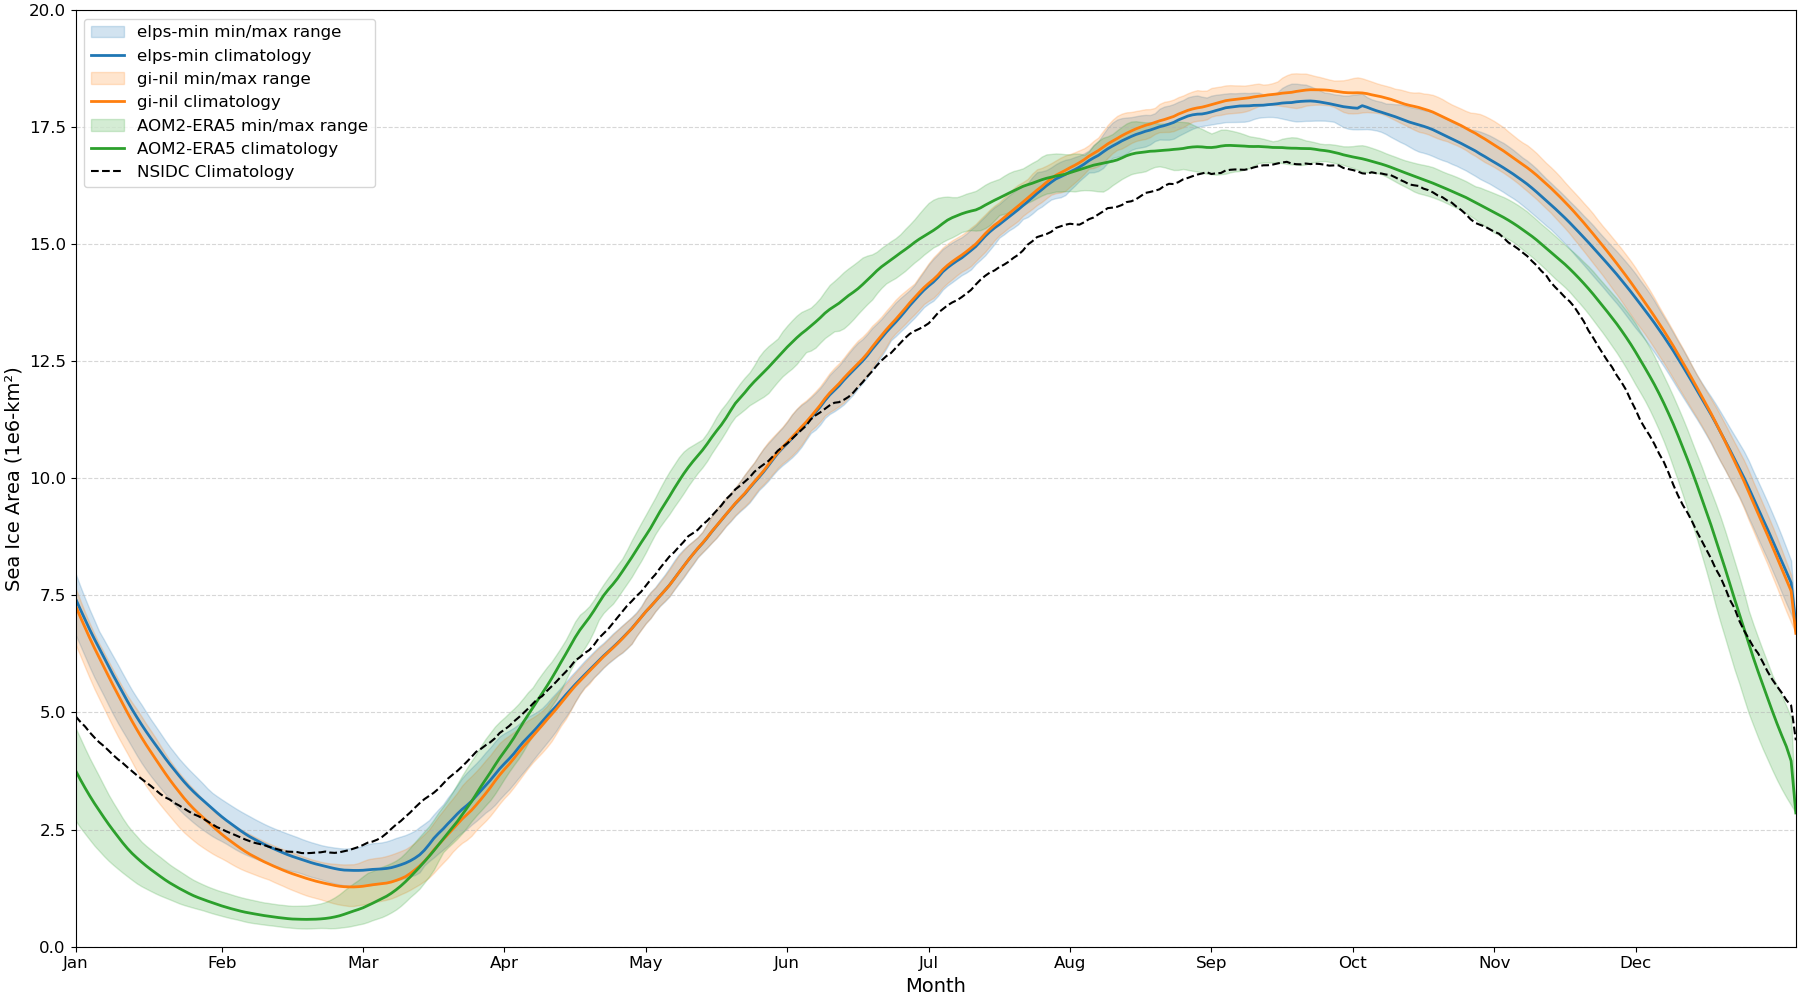

In [9]:
Image(filename='/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/SIA_elps-min_gi-nil_AOM2-ERA5_1994-1999.png')

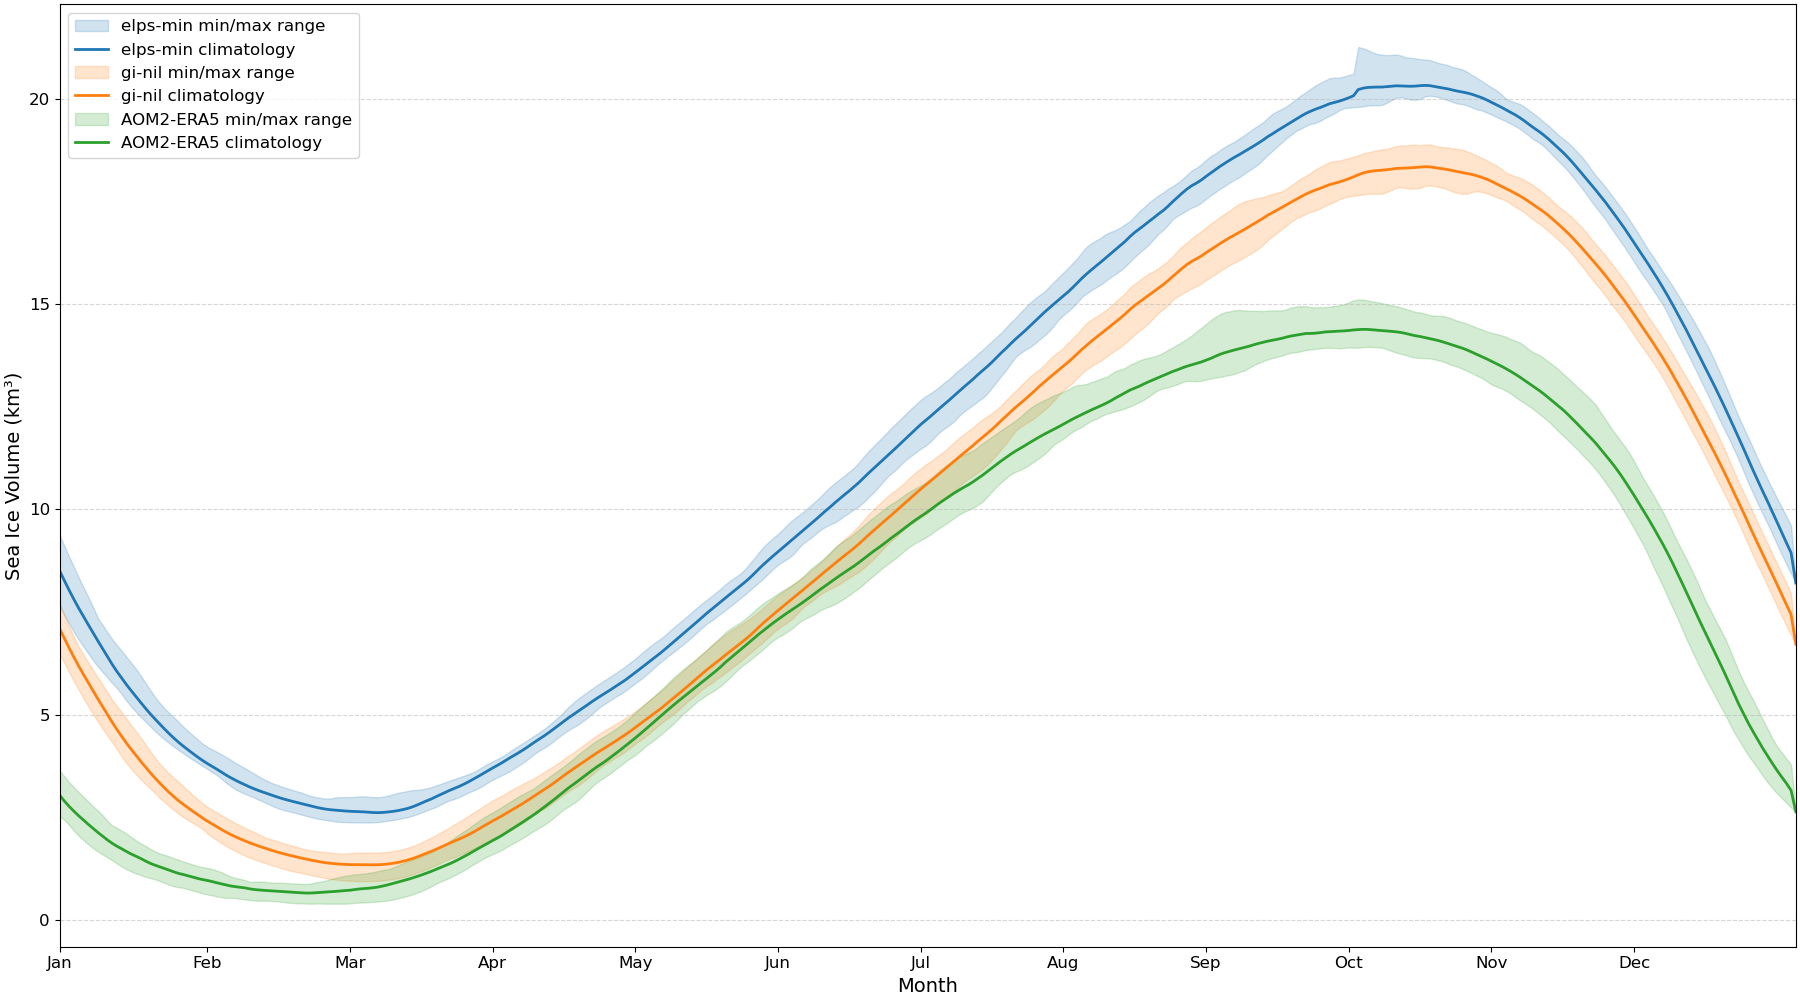

In [9]:
Image(filename='/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/SIV_elps-min_gi-nil_AOM2-ERA5_1994-1999.png')

### Spatial Comaprisons

In [13]:
sim_name  = "AOM2-ERA5"
var_name  = "ispd_BT"
region    = "Aus"
SI_tools  = SeaIceToolbox(sim_name = sim_name)
CICE_all  = SI_tools.load_iceh_zarr()
CICE_ispd = SI_tools.compute_ice_magnitude_from_ice_components_on_Bgrid( CICE_all , ['BT'] )
for i in np.arange(2400,2500,1):
    ds_slice = CICE_ispd.isel(time=i, nj=SI_tools.hemisphere_dict['nj_slice'])
    plt_da   = ds_slice[var_name]
    dt       = pd.Timestamp( plt_da.time.values )
    dt_str   = f"{dt.year}-{dt.month:02d}-{dt.day:02d}"
    SI_tools.pygmt_map_plot_one_var(plt_da, var_name,
                                    plot_regions  = 8,
                                    time_stamp    = dt_str,
                                    tit_str       = dt_str,
                                    plot_GI       = False,
                                    var_sq_size   = 0.2,
                                    series        = (0,.5),
                                    GI_fill_color = 'red', 
                                    GI_sq_size    = 0.075,
                                    extend_cbar   = True,
                                    show_fig      = False)

In [26]:
sim_name = "gi-nil"
var_name = "ispd_BT"
region   = "Aus"
SI_tools  = SeaIceToolbox(sim_name = sim_name)
D_png = Path(SI_tools.D_graph,sim_name,region,var_name)
D_ani = Path(SI_tools.D_graph,"animations",sim_name,var_name)
P_mp4 = Path(Path.home(),"AFIM","src","AFIM","docs","figures",f"{sim_name}_{var_name}_{region}_1999-winter.mp4")
D_ani.mkdir(parents=True, exist_ok=True)
frames = sorted([f for f in os.listdir(D_png) if f.endswith(".png")])
os.system(f"rm {SI_tools.D_tmp}/frame_*.png")
for i, f in enumerate(frames):
    src = Path(D_png,f)
    dst = Path(SI_tools.D_tmp,f"frame_{i:04d}.png")
    os.symlink(src, dst)
os.system(f"ffmpeg -y -r 2 -i {SI_tools.D_tmp}/frame_%04d.png -c:v libx264 -pix_fmt yuv420p {P_mp4}")

##### ``elps-min``: e = 2, ktens = 0.2, gi-min = 0.25

In [11]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_ispd_BT_Aus_1999-winter.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

##### ``AOM2-ERA5``: e = 2, ktens = None, gi-min = None

In [21]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/AOM2-ERA5_ispd_BT_Aus_1999-winter.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

##### ``gi-nil``: e = 2, ktens = 0.2, gi-min = None

In [25]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/gi-nil_ispd_BT_Aus_1999-winter.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

## Can we realistically simulate the:

1.  fast ice area min

2.  fast ice area max

3.  seasonality

4.  thickness

5.  inter-annual variability

6.  (all the while maintaining pack ice -- see below)

In [ ]:
sim_name   = "elps-min"
dt0_str    = "1993-01-01"
dtN_str    = "1999-12-31"
dt_rng_str = f"{dt0_str[:4]}-{dtN_str[:4]}"
ice_type   = "FI_BT"
SIA_dict   = {}
FIA_dict   = {}
SI_tools   = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str,
                           ice_speed_threshold  = 5e-4,
                           ice_speed_type       = "ispd_BT",
                           ice_type             = "FI_BT",
                           overwrite_zarr       = False,
                           save_new_figs        = True,
                           show_figs            = True,
                           overwrite_saved_figs = True)
FIA_dict["AF2020db_cli"] = SI_tools.interpolate_obs_fia( pd.read_csv(SI_tools.AF_FI_dict['P_AF2020_cli_csv']) )
for i_type in ["FI_BT_bool"]:
    P_METS = Path(SI_tools.D_metrics, f"{i_type}_mets.zarr")
    P_sum  = Path(SI_tools.D_metrics, f"{i_type}_summary.csv")
    if P_METS.exists() and not SI_tools.overwrite_zarr_group:
        print(f"{P_METS} exists and not overwriting--loading")
        METS             = xr.open_zarr(P_METS)
        FIA_dict[i_type] = METS['FIA']
    else:
        print(f"{P_METS} does NOT exists and/or overwriting--computing")
        roll        = i_type.endswith("_roll")
        DS, CICE_SO = SI_tools.load_processed_cice(ice_type    = ice_type,
                                                  zarr_CICE   = True,
                                                  rolling     = roll,
                                                  slice_hem   = True)
        if i_type==f"{ice_type}_bool":
            bool_mask          = SI_tools.boolean_fast_ice(DS['FI_mask'], dim="time", window=7, min_count=6)
            DS_bool            = CICE_SO.where(bool_mask)
            DS_bool["FI_mask"] = DS["FI_mask"]
            DS                 = DS_bool
        METS = SI_tools.compute_sea_ice_metrics(DS, sim_name, i_type, SI_tools.ispd_thresh_str, P_METS, P_sum, FIA_dict["AF2020db_cli"])
        FIA_dict[i_type] = METS['FIA']
P_png = Path(SI_tools.D_graph, sim_name, f"FIA_{sim_name}_{dt_rng_str}.png")
SI_tools.plot_FIA_FIP_faceted(FIA_dict, METS['FIP'], P_png=P_png, enable_FIP=False, plot_GI=True, FIA_ylim=(100,700))

In [ ]:
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_elps-min_1993-1999.png")

In [ ]:
sim_name   = "elps-min"
var_name   = "aice"
dt0_str    = "1993-01-01"
dtN_str    = "1999-12-31"
dt_rng_str = f"{dt0_str[:4]}-{dtN_str[:4]}"
ice_type   = "FI_BT"
SIA_dict   = {}
FIA_dict   = {}
SI_tools   = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str,
                           ice_speed_threshold  = 5e-4,
                           ice_speed_type       = "ispd_BT",
                           ice_type             = "FI_BT",
                           overwrite_zarr       = True,
                           save_new_figs        = True,
                           show_figs            = True,
                           overwrite_saved_figs = True)
CICE_all   = SI_tools.load_iceh_zarr()
for i in np.arange(2400,2500,1):
    ds_slice = CICE_all.isel(time=i)#, nj=SI_tools.hemisphere_dict['nj_slice'])
    plt_da   = ds_slice[var_name]
    dt       = pd.Timestamp( plt_da.time.values )
    dt_str   = f"{dt.year}-{dt.month:02d}-{dt.day:02d}"
    SI_tools.pygmt_map_plot_one_var(plt_da, var_name,
                                    plot_regions  = None,
                                    time_stamp    = dt_str,
                                    tit_str       = dt_str,
                                    plot_GI       = True,
                                    var_sq_size   = 0.2,
                                    GI_fill_color = 'red', 
                                    GI_sq_size    = 0.01,
                                    extend_cbar   = True,
                                    show_fig      = False)

In [ ]:
def img_to_base64(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")
# Full paths to your images
img1_path = "/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/north/aice/1999-08-13_elps-min_north_aice.png"
img2_path = "/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/south/aice/1999-08-13_elps-min_south_aice.png"
# Encode the images
img1_b64 = img_to_base64(img1_path)
img2_b64 = img_to_base64(img2_path)
# HTML block to render both images
html = f"""
<div style="display: flex; gap: 20px;">
  <img src="data:image/png;base64,{img1_b64}" width="600"/>
  <img src="data:image/png;base64,{img2_b64}" width="600"/>
</div>
"""
display(HTML(html))

## Which CICE parameter(s) is the model most sensitive to?

1.  rheological parameters

2.  What is the optimal concentration of grounded icebergs that should
    be used?

3.  Is there a relationship between sea ice speed threshold and fast ice
    area?

## Do the thermodynamics and mechanical dynamics continue to \`\`behave\'\' when CICE is *heavily tuned* for fast ice?

(limited due to standalone configuration)

### Is there a relationship between sea ice speed threshold and fast ice area?

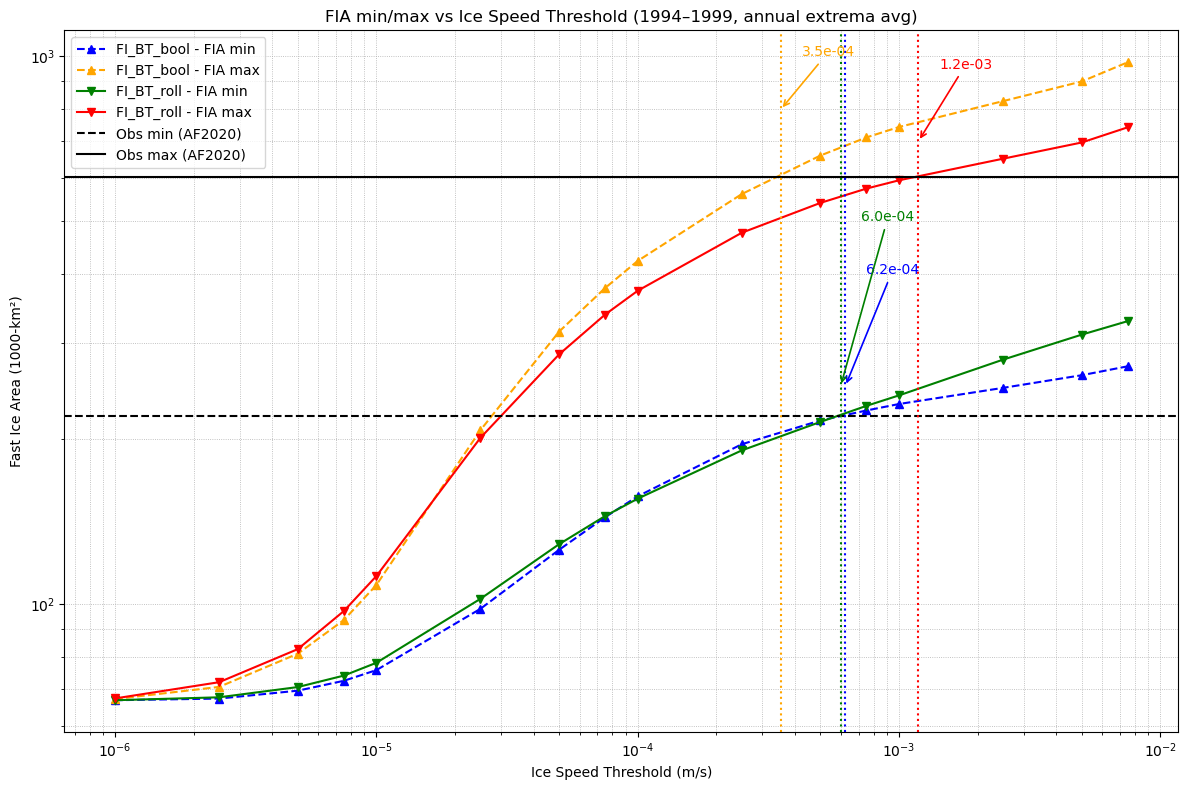

<Figure size 640x480 with 0 Axes>

In [39]:
log_scale = True  # Set to False for linear
if log_scale:
    F_name = "ispd-thresh_vs_FIA-min-max_logscale.png"
else:
    F_name = "ispd-thresh_vs_FIA-min-max.png"
sim_name = "elps-min"
base_dir = f"/g/data/gv90/da1339/afim_output/{sim_name}/zarr"
threshold_dirs = sorted([d for d in os.listdir(base_dir) if d.startswith("ispd_thresh_")])
ispd_vals = [float(d.split('_')[2]) for d in threshold_dirs]
FIA_stats = {"FI_BT_bool": {},
             "FI_BT_roll": {}}
def get_fia_stats(path):
    try:
        ds = xr.open_zarr(path)
        fia = ds["FIA"].sel(time=slice("1994-01-01", "1999-12-31"))
        # Group by year and compute annual min/max
        fia_by_year = fia.groupby("time.year")
        min_by_year = fia_by_year.min(dim="time")
        max_by_year = fia_by_year.max(dim="time")
        # Compute the mean of annual min/max
        return float(min_by_year.mean().values), float(max_by_year.mean().values)
    except Exception as e:
        print(f"Error with {path}: {e}")
        return np.nan, np.nan
# Define a function to interpolate where the method curve crosses the observed value
def interpolate_x(x, y, y_obs):
    x = np.array(x)
    y = np.array(y)
    for i in range(len(x) - 1):
        if np.isnan(y[i]) or np.isnan(y[i + 1]):
            continue
        if (y[i] - y_obs) * (y[i + 1] - y_obs) < 0:
            # Linear interpolation in log or linear space depending on axis setting
            return x[i] + (y_obs - y[i]) * (x[i + 1] - x[i]) / (y[i + 1] - y[i])
    return None

for dir_name in threshold_dirs:
    threshold = float(dir_name.split("_")[2])
    # Paths
    bool_path = os.path.join(base_dir, dir_name, "metrics", "FI_BT_bool_mets.zarr")
    roll_path = os.path.join(base_dir, dir_name, "metrics", "FI_BT_roll_mets.zarr")
    # Load stats
    min_b, max_b = get_fia_stats(bool_path)
    min_r, max_r = get_fia_stats(roll_path)
    # Store in dict
    FIA_stats["FI_BT_bool"][threshold] = {"min": min_b, "max": max_b}
    FIA_stats["FI_BT_roll"][threshold] = {"min": min_r, "max": max_r}

# Sort thresholds
thresholds = sorted(FIA_stats['FI_BT_bool'].keys())

# Prepare data
bool_min = [FIA_stats['FI_BT_bool'][t]['min'] for t in thresholds]
bool_max = [FIA_stats['FI_BT_bool'][t]['max'] for t in thresholds]
roll_min = [FIA_stats['FI_BT_roll'][t]['min'] for t in thresholds]
roll_max = [FIA_stats['FI_BT_roll'][t]['max'] for t in thresholds]
# Compute interpolated x-values for each intersection
bool_min_x = interpolate_x(thresholds, bool_min, obs_min)
bool_max_x = interpolate_x(thresholds, bool_max, obs_max)
roll_min_x = interpolate_x(thresholds, roll_min, obs_min)
roll_max_x = interpolate_x(thresholds, roll_max, obs_max)

# Observed min/max
obs_min = 221
obs_max = 601

plt.figure(figsize=(12, 8))
if log_scale:
    plt.xscale("log")
    plt.yscale("log")

# Plot the curves
plt.plot(thresholds, bool_min, 'b--', marker='^', label="FI_BT_bool - FIA min")
plt.plot(thresholds, bool_max, 'orange', linestyle='--', marker='^', label="FI_BT_bool - FIA max")
plt.plot(thresholds, roll_min, 'g-', marker='v', label="FI_BT_roll - FIA min")
plt.plot(thresholds, roll_max, 'r-', marker='v', label="FI_BT_roll - FIA max")

# Horizontal obs lines
plt.axhline(obs_min, color='k', linestyle='--', label="Obs min (AF2020)")
plt.axhline(obs_max, color='k', linestyle='-', label="Obs max (AF2020)")

# Arrow annotations for vertical thresholds
arrowprops = dict(arrowstyle="->", linewidth=1.2)

if bool_min_x:
    plt.axvline(bool_min_x, color='blue', linestyle=':')
    plt.annotate(f"{bool_min_x:.1e}",
                 xy=(bool_min_x, 250), xytext=(bool_min_x * 1.2, 400),
                 arrowprops={**arrowprops, 'color': 'blue'}, color='blue')

if bool_max_x:
    plt.axvline(bool_max_x, color='orange', linestyle=':')
    plt.annotate(f"{bool_max_x:.1e}",
                 xy=(bool_max_x, 800), xytext=(bool_max_x * 1.2, 1000),
                 arrowprops={**arrowprops, 'color': 'orange'}, color='orange')

if roll_min_x:
    plt.axvline(roll_min_x, color='green', linestyle=':')
    plt.annotate(f"{roll_min_x:.1e}",
                 xy=(roll_min_x, 250), xytext=(roll_min_x * 1.2, 500),
                 arrowprops={**arrowprops, 'color': 'green'}, color='green')

if roll_max_x:
    plt.axvline(roll_max_x, color='red', linestyle=':')
    plt.annotate(f"{roll_max_x:.1e}",
                 xy=(roll_max_x, 700), xytext=(roll_max_x * 1.2, 950),
                 arrowprops={**arrowprops, 'color': 'red'}, color='red')

# Labels and formatting
plt.xlabel("Ice Speed Threshold (m/s)")
plt.ylabel("Fast Ice Area (1000-km²)")
plt.title("FIA min/max vs Ice Speed Threshold (1994–1999, annual extrema avg)")
plt.legend()
plt.grid(True, which='both' if log_scale else 'major', linestyle=':', linewidth=0.6)
plt.tight_layout()
plt.show()
plt.savefig(f"/g/data/gv90/da1339/GRAPHICAL/AFIM/{sim_name}/{F_name}")